<AxesSubplot:xlabel='X', ylabel='y'>

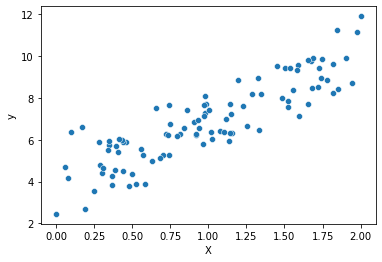

In [145]:
import numpy as np
import seaborn  as sns
import pandas as pd

# Create data set for linear regression
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
rand_n = pd.DataFrame(np.concatenate((X,y), axis=1), columns=['X','y'])
sns.scatterplot(data=rand_n, x='X', y='y')

In [146]:
# Solve for best thetas
X_b = np.c_[np.ones((100,1)), X]
theta_best = (
    np.linalg
    .inv(X_b.T.dot(X_b))
    .dot(X_b.T).dot(y)
)
theta_best

array([[3.81306117],
       [3.10374245]])

In [147]:
# Make predictions using best theta
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.81306117],
       [10.02054606]])

(0.0, 2.0, 0.0, 15.0)

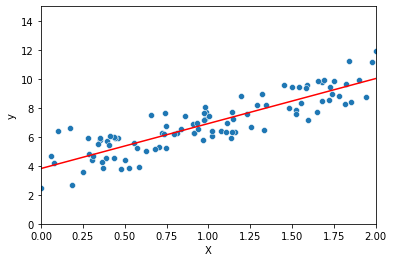

In [148]:
import matplotlib.pyplot as plt
sns.scatterplot(data=rand_n, x='X', y='y')
plt.plot(X_new,y_predict,'r-')
plt.axis([0,2,0,15])

#### Linear regression using Scikit-Learn

In [149]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.81306117]), array([[3.10374245]]))

In [150]:
lin_reg.predict(X_new)

array([[ 3.81306117],
       [10.02054606]])

In [151]:
# Implemnetation of gradient decent
import numpy as np

eta = 0.1
n_iterations = 1000
m = 100
vals = []
theta = np.random.randn(2,1)
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    vals.append(theta)

theta

array([[3.81306117],
       [3.10374245]])

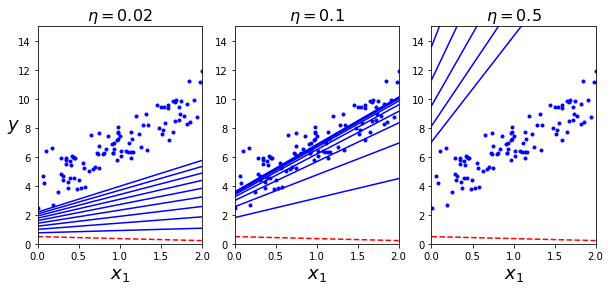

In [152]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)



Stochastic Gradient Descent w/ simple learning schedule

In [153]:
n_epochs = 50
t0, t1 = 5, 50
m = 100

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        # Get random slice index of data
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        # Calculate the gradient vector
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # Define the learning schedule
        eta = learning_schedule(epoch * m + i) # learning schedule gets smaller at every step.
        # Using the gradient vector, evaluate the gradient decent step. Move towards theta values towards true values.
        theta = theta - eta * gradients
        # after every training cycle in each epoch, the gradient vector get closer to true theta value.
# m = number of observations
# m is not used in the stochastic gradient function because each cost function is evaluated for each instance instead as a whole.

theta


array([[3.86410527],
       [3.09332285]])

what does the gradient represent?

* It represents the gradient descent step.

In [154]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    max_iter=1000, 
    tol=1e-3, # tolerance - code will run for 1000 iteration or loss drops by less the 1e-3
    penalty=None, # no regularization
    eta0=0.1 # learning rate
)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [155]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.80822973]), array([3.09359103]))

# Polynomial Regression

<AxesSubplot:xlabel='X', ylabel='y'>

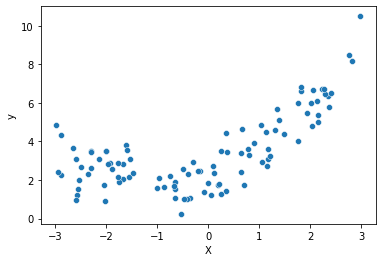

In [156]:
import pandas as pd

m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)
origin = pd.DataFrame(zip(X.flatten(),y.flatten()), columns=['X','y'])
sns.scatterplot(x = 'X', y = 'y', data=origin)

In [157]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_,lin_reg.coef_

(array([2.28405711]), array([[0.88171323, 0.44446033]]))

<AxesSubplot:xlabel='X', ylabel='y'>

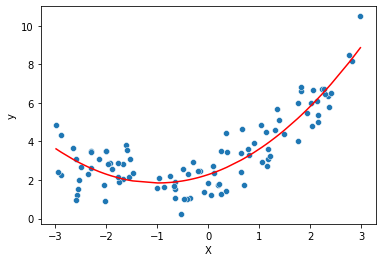

In [158]:
import seaborn as sns

y_vals = [lin_reg.intercept_ + lin_reg.coef_.dot(val) for val in X_poly]
y_vals = [x[0] for x in y_vals]
df = pd.DataFrame(zip(X.flatten(),y_vals), columns=['X','y'])

sns.lineplot(data=df, x='X', y='y',color='red')
sns.scatterplot(x = 'X', y = 'y', data=origin)

## Learning Curves

Learning curves plots the models's performance on the training set and the validation set as a funciton of the training set size (or the training iteration).

In [159]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split (
        X, y, test_size=0.2
    )
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend()

(0.0, 3.0)

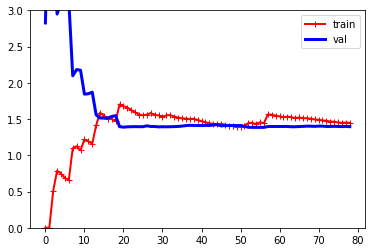

In [160]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.ylim(top=3, bottom=0)

If the model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with beter features.

(0.0, 3.0)

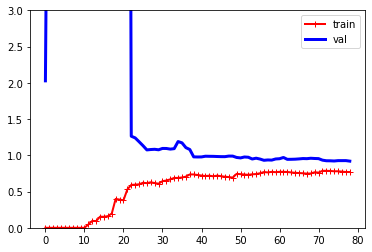

In [161]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])
plot_learning_curves(polynomial_regression, X, y)
plt.ylim(top=3, bottom=0)

Bias 

- Thi part of the generalisation error is due to wrong assumptions, such as assiming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data

Variance

- This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as high-degree polynomial model) is likely to have high variance and thus overfit the training data.

Irreducible error

- This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (fix the data sources such as broken sensors or detect and remove outliers)
